# HTS [Part 1]

In [14]:
%pylab inline
import sys
from ipywidgets import interact

sys.path.append('src')
from motorControl import *
from trajectoryPlanning import *
rc = connect(portName = "/dev/tty.usbserial-A9ETDN3N")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Initialized Motor Classes

- Really important to initialze these first to restore positions from last session!

In [15]:
#Initialize motor objects for each motor:
vL = Motor(address = 0x81, motorNumber = 2, rc = rc, signFlipped = False, \
           motorCounter = 0, kPID = [1e-2, 1.0])
vR = Motor(address = 0x81, motorNumber = 1, rc = rc, signFlipped = False, \
           motorCounter = 1, kPID = [1e-2, 1.0])
LR = Motor(address = 0x80, motorNumber = 1, rc = rc, signFlipped = False, 
           motorCounter = 2, kPID = [1e-2, 1.0])
FB = Motor(address = 0x80, motorNumber = 2, rc = rc, signFlipped = True, \
           motorCounter = 3, kPID = [1e-2, 1.0])
yaw = Motor(address = 0x82, motorNumber = 2, rc = rc, signFlipped = False, \
            motorCounter = 4, kPID = [1e-2, 1.0])
pitch = Motor(address = 0x82, motorNumber = 1, rc = rc, signFlipped = False, \
              motorCounter = 5, kPID = [1e-2, 1.0])

#Keep in a nice motor list:
motors = [vL, vR, LR, FB, yaw, pitch]

In [16]:
getPositions(motors)

[13, -18, -69117, 58500, 19, 45288]

In [17]:
interact(manualControl, leftUD = (-50, 50), rightUD = (-50, 50), leftRight = (-50, 50), \
         fB = (-50, 50), tilt = (-50, 50), pan = (-50, 50))

<function motorControl.manualControl>

In [18]:
stopAll(rc)
savePositions(motors)
getPositions(motors)

[13, -18, -69117, 58500, 19, 45288]

### Reset Tilt Position

In [47]:
#motors[5].rc.SetEncM1(motors[5].address, 45296)

In [84]:
getPositions(motors)

[-136, 126, -139072, 18375, 34083, -2147]

In [49]:
position1

[0, 0, -69159, 58530, 0, 45296]

In [61]:
position3

[-64139, 64775, -137650, 79063, 16885, 8579]

## Save a new position

In [92]:
# f = open('savedPositions/home2.p', 'wb')
# pickle.dump(getPositions(motors), f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

## Load up old positions!

In [19]:
f = open('savedPositions/home.p', 'r')
home = pickle.load(f)
f.close()

f = open('savedPositions/home2.p', 'r')
home2 = pickle.load(f)
f.close()


f = open('savedPositions/position1.p', 'r')
position1 = pickle.load(f)
f.close()

f = open('savedPositions/position2.p', 'r')
position2 = pickle.load(f)
f.close()

f = open('savedPositions/position3.p', 'r')
position3 = pickle.load(f)
f.close()

f = open('savedPositions/position4.p', 'r')
position4 = pickle.load(f)
f.close()

f = open('savedPositions/position5.p', 'r')
position5 = pickle.load(f)
f.close()

f = open('savedPositions/position6.p', 'r')
position6 = pickle.load(f)
f.close()

## Move the rig

In [53]:
targetPositions = position3
totalTime = 20.0
rampTime = 5.0

startingPositions = getPositions(motors)
lookAheadTime = 1.0
tolerance = 100.0 #Anything less than this many ticks we're calling "Not a move"

motorsToMove = []
targetPositionsToMove = []
for i, motor in enumerate(motors):
    if abs(motor.getPosition()-targetPositions[i]) > tolerance:
        motorsToMove.append(motor)
        targetPositionsToMove.append(targetPositions[i])
        
trajectories = []
for i, motor in enumerate(motorsToMove):
    trajectories.append(SimpleQuadraticTrajectory(tu = rampTime, tt = totalTime, \
                                            p1 = motor.getPosition(), p2 = targetPositionsToMove[i]))
    
print np.array(targetPositions) - startingPositions
print len(motorsToMove)

[   -96     75    -82     11 -19533 -19537]
2


In [54]:
for motor in motorsToMove:
    motor.initialize(targetVelocityMin = -2500.0, targetVelocityMax = 2500.0)
    motor.clearTracking()
    
startTime = time.time()
timeElapsed = 0.0
    
while timeElapsed < totalTime:
    timeElapsed = time.time()-startTime
    
    for i, motor in enumerate(motorsToMove):
        lookAheadValue = trajectories[i].compute(timeElapsed + lookAheadTime)
        motor.controlledMove(targetPosition = lookAheadValue, timeToReach = lookAheadTime)

stopAll(rc)
savePositions(motors)
print getPositions(motors), targetPositions
print getPositions(motors) - np.array(targetPositions)

[-63963, 64624, -137479, 78992, 16990, 7548] [-64059, 64699, -137561, 79003, 16866, 7428]
[ 96 -75  82 -11 124 120]


In [22]:
stopAll(rc)
savePositions(motors)

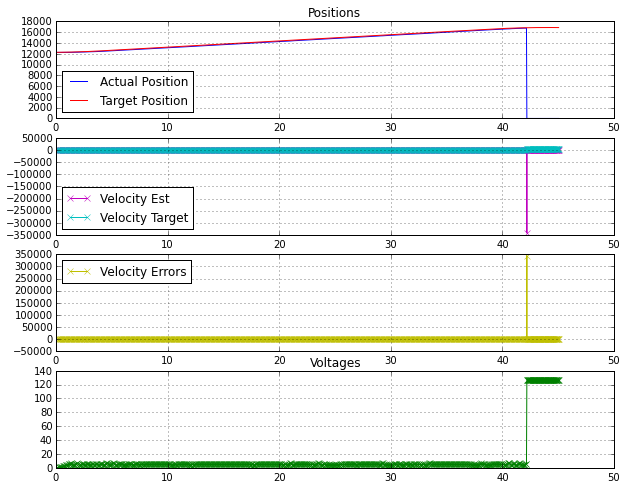

In [26]:
yaw.visualizeMove()

In [51]:
getPositions(motors)

[-63963, 64624, -137479, 78992, 36399, 26965]